# Case 1: Predicting with texts


# Lexicon-based sentiment analysis


## Data importing and cleaning


In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import warnings
from adjustText import adjust_text
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from afinn import Afinn

warnings.simplefilter("ignore", MarkupResemblesLocatorWarning)
pd.set_option('display.max_colwidth', 50)
print("Current working directory: ", os.getcwd())
wd = os.getcwd()
# If current working directory is incorrect, use os.chdir("path")
# Edit the name of the data file from "Movie Review" into "MovieReview"
# and should be contained in the current working directory

Current working directory:  /Users/swislar/Desktop


In [3]:
def filterWords(TEXT):
    '''
    TEXT: String of the sentence
    RETURN: List of clean words
    '''
    # Remove HTML Tags and stop words
    stop_words = set(stopwords.words("english"))
    clean = BeautifulSoup(TEXT, "html.parser").get_text()
    words = [word.lower() for word in word_tokenize(
        clean) if word.isalnum() and word.lower() not in stop_words]
    return words


def loadAllData(WD=os.getcwd()):
    '''
    WD: Current working directory containing datasets- os.getcwd() 
    RETURN: Pandas Dataframe
    '''
    # Initialise the dataframe
    columns = ["id", "text"]
    rows = []
    posWD = os.path.join(WD, "MovieReview/data/pos")
    negWD = os.path.join(WD, "MovieReview/data/neg")
    # Read positively classified text
    for filename in tqdm(os.listdir(posWD), desc='Processing Positive Reviews'):
        with open(os.path.join(posWD, filename), "r") as file:
            posText = filterWords(file.read())
        # Strip .txt from filename and split ID and Rating as an integer
        posDetails = filename.rstrip(".txt").split("_")
        posID = int(posDetails[0])
        # Add data into the Dataframe
        row = {"id": posID, "text": posText}
        rows.append(row)
    # Repeat for negative text
    for filename in tqdm(os.listdir(negWD), desc='Processing Negative Reviews'):
        with open(os.path.join(negWD, filename), "r") as file:
            negText = filterWords(file.read())
        negDetails = filename.rstrip(".txt").split("_")
        # Offset id by 25000 to prevent overlaps
        negID = int(negDetails[0]) + 25000
        row = {"id": negID, "text": negText}
        rows.append(row)
    return pd.DataFrame(rows, columns=columns)

In [4]:
dataframe = loadAllData()

Processing Negative Reviews: 100%|██████████| 25000/25000 [00:27<00:00, 911.60it/s]


## Main (Afinn)


The Affective Norms for English Words (AFINN) sentiment lexicon contains a list of words along with their associated sentiment scores, representing the polarity or emotional valence of each word.


In [5]:
# Lexicon-based sentiment analysis
afinn = Afinn()

# Takes approximately 1min to load
dataframe["sentiment_score"] = dataframe["text"].apply(
    lambda row: sum(afinn.score(word) for word in row))

# Classify sentiment based on the total score
dataframe["sentiment"] = dataframe["sentiment_score"].apply(
    lambda res: 1 if (res > 0) else 0)

In [6]:
dataframe["actual_sentiment"] = dataframe["id"].apply(
    lambda id: 1 if id <= 25000 else 0)
dataframe.head(5)

,id,text,sentiment_score,sentiment,actual_sentiment
0,20935,"[watched, return, lonesome, dove, good, seen, ...",10.0,1,1
1,12390,"[movie, looked, like, classic, cheesy, 80s, sl...",-19.0,0,1
2,9820,"[jay, chou, plays, orphan, raised, kung, fu, s...",30.0,1,1
3,883,"[ooverall, movie, fairly, good, good, action, ...",2.0,1,1
4,9063,"[movie, fun, watch, liked, dave, kevin, klein,...",0.0,0,1


## Model evalutaiton


In order to evaluate the effectiveness of the AFINN senitment lexicon, we compare the polarity of the text computed from the sentiment score with the actual sentiment of the text. </br>
A negative sentiment score suggests a negative sentiment while a positive sentiment score suggests a positive sentiment.


In [7]:
acc = sum(dataframe["sentiment"] ==
          dataframe["actual_sentiment"])/dataframe.shape[0]
print(f'The accuracy of using the Lexicon-based sentiment analysis is {acc}')

The accuracy of using the Lexicon-based sentiment analysis is 0.70176


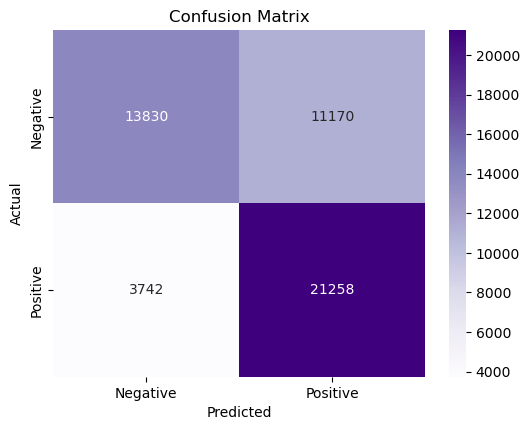

In [8]:
conf_matrix = confusion_matrix(
    dataframe["actual_sentiment"], dataframe["sentiment"])

# Plot confusion matrix
plt.figure(figsize=(6, 4.5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=[
            'Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

To determine identify the issues that cause a wrong classification of sentiment, we filter out the false positives and false negatives.


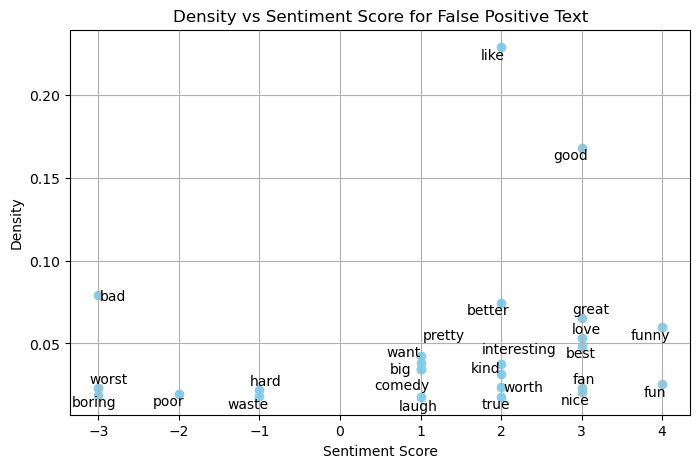

In [14]:
# Filter out false positives
false_pos = dataframe[(dataframe["actual_sentiment"] == 0)
                      & (dataframe["sentiment"] == 1)]
# Retrieve individual words with its frequency
pos_wordBank = dict()
for wordli in false_pos["text"]:
    for word in wordli:
        if word not in pos_wordBank:
            pos_wordBank[word] = 1
        else:
            pos_wordBank[word] += 1

word_densities = list(pos_wordBank.items())
word_densities.sort(key=lambda x: -x[1])
top_25_false_pos = [(word, density) for word,
                    density in word_densities if afinn.score(word) != 0][:25]

word_densities = [x[1]/50000 for x in top_25_false_pos]
word_sentiments = [afinn.score(x[0]) for x in top_25_false_pos]
word_labels = [x[0] for x in top_25_false_pos]

# Plot scatter plot with annotations
plt.figure(figsize=(8, 5))
plt.scatter(word_sentiments, word_densities, color='skyblue',
            alpha=1)
plt.title(f'Density vs Sentiment Score for False Positive Text')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.grid(True)

# Annotate each point with the corresponding word
texts = []
for i, label in enumerate(word_labels):
    texts.append(plt.text(
        word_sentiments[i], word_densities[i], label, ha='center', va='center'))
# Adjust text to avoid overlap
adjust_text(texts)

plt.show()

From this plot, we can observe that false positives generally contain a greater number of words that has a positive sentiment.


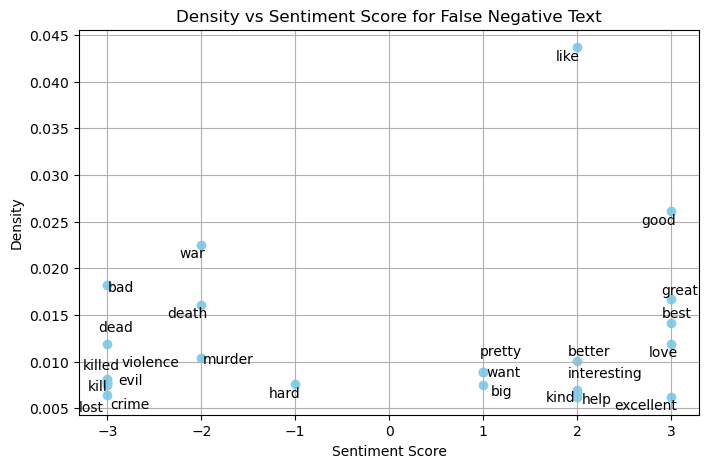

In [15]:
# Filter out false positives
false_neg = dataframe[(dataframe["actual_sentiment"] == 1)
                      & (dataframe["sentiment"] == 0)]
# Retrieve individual words with its frequency
neg_wordBank = dict()
for wordli in false_neg["text"]:
    for word in wordli:
        if word not in neg_wordBank:
            neg_wordBank[word] = 1
        else:
            neg_wordBank[word] += 1

word_densities = list(neg_wordBank.items())
word_densities.sort(key=lambda x: -x[1])
top_25_false_neg = [(word, density) for word,
                    density in word_densities if afinn.score(word) != 0][:25]

word_densities = [x[1]/50000 for x in top_25_false_neg]
word_sentiments = [afinn.score(x[0]) for x in top_25_false_neg]
word_labels = [x[0] for x in top_25_false_neg]

# Plot scatter plot with annotations
plt.figure(figsize=(8, 5))
plt.scatter(word_sentiments, word_densities, color='skyblue',
            alpha=1)
plt.title(f'Density vs Sentiment Score for False Negative Text')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.grid(True)

# Annotate each point with the corresponding word
texts = []
for i, label in enumerate(word_labels):
    texts.append(plt.text(
        word_sentiments[i], word_densities[i], label, ha='center', va='center'))
# Adjust text to avoid overlap
adjust_text(texts)

plt.show()

Similarly false negatives contain slightly more negative words of a lower sentiment score than words of positive sentiment.


# Kmeans


## Data importing and cleaning


In [17]:
import os
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import warnings
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

warnings.simplefilter("ignore", MarkupResemblesLocatorWarning)
pd.set_option('display.max_colwidth', 50)
print("Current working directory: ", os.getcwd())
wd = os.getcwd()
# If current working directory is incorrect, use os.chdir("path")
# Edit the name of the data file from "Movie Review" into "MovieReview"
# and should be contained in the current working directory

Current working directory:  /Users/swislar/Desktop/IT1244/Project


In [19]:
def filterWords(TEXT):
    '''
    TEXT: String of the sentence
    RETURN: List of clean words
    '''
    # Remove HTML Tags and stop words
    stop_words = set(stopwords.words("english"))
    clean = BeautifulSoup(TEXT, "html.parser").get_text()
    words = [word.lower() for word in word_tokenize(
        clean) if word.isalnum() and word.lower() not in stop_words]
    return words


def loadAllData(WD=os.getcwd()):
    '''
    WD: Current working directory containing datasets- os.getcwd() 
    RETURN: Pandas Dataframe
    '''
    # Initialise the dataframe
    columns = ["id", "text"]
    rows = []
    posWD = os.path.join(WD, "MovieReview/data/pos")
    negWD = os.path.join(WD, "MovieReview/data/neg")
    # Read positively classified text
    for filename in tqdm(os.listdir(posWD), desc='Processing Positive Reviews'):
        with open(os.path.join(posWD, filename), "r") as file:
            posText = filterWords(file.read())
        # Strip .txt from filename and split ID and Rating as an integer
        posDetails = filename.rstrip(".txt").split("_")
        posID = int(posDetails[0])
        # Add data into the Dataframe
        row = {"id": posID, "text": posText}
        rows.append(row)
    # Repeat for negative text
    for filename in tqdm(os.listdir(negWD), desc='Processing Negative Reviews'):
        with open(os.path.join(negWD, filename), "r") as file:
            negText = filterWords(file.read())
        negDetails = filename.rstrip(".txt").split("_")
        # Offset id by 25000 to prevent overlaps
        negID = int(negDetails[0]) + 25000
        row = {"id": negID, "text": negText}
        rows.append(row)
    return pd.DataFrame(rows, columns=columns)

In [20]:
data = loadAllData()

Processing Negative Reviews: 100%|██████████| 25000/25000 [00:26<00:00, 930.12it/s]


The data is first passed into the Term Frequency-Inverse Document Frequency Vectorizer (TfidfVectorizer), which is used for converting raw text data into numerical feature representations based on TF-IDF values which is a sparse matrix. This enables efficient text analysis and machine learning on text data.


In [21]:
data['text'] = data['text'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer()
text_vect = vectorizer.fit_transform(data['text'])

print(
    f'Dimension of vectorizer: {text_vect.shape[0]} rows and {text_vect.shape[1]} columns')

Dimension of vectorizer: 50000 rows and 100299 columns


## Main


In [22]:
# K-means clustering
kmeans = KMeans(n_clusters=2, n_init=20, random_state=99)
kmeans.fit(text_vect)

# Add cluster labels to the dataframe
data['cluster_label'] = kmeans.labels_

print(data[data['cluster_label'] == 0].head())
print(data[data['cluster_label'] == 1].head())

       id                                               text  cluster_label
1   12390  movie looked like classic cheesy 80s slasher g...              0
5   10186  loved movie fact loved actress movie iwas feat...              0
21  22311  movie maker know hard tell story draw people s...              0
23  13390  bad movie could done without full frontal nudi...              0
25   8820  comic book reader still sees total kid heart a...              0
      id                                               text  cluster_label
0  20935  watched return lonesome dove good seen lot neg...              1
2   9820  jay chou plays orphan raised kung fu school ki...              1
3    883  ooverall movie fairly good good action plot fa...              1
4   9063  movie fun watch liked dave kevin klein get kic...              1
6  22540  andaz apna apna favorite comedy movie aamir sa...              1


## Model evaluation


To visualise the result of k-means groupings, dimension reduction is used for plotting onto a 2-Dimensional space.


In [25]:
# Dimension Reduction
svd = TruncatedSVD(n_components=2, random_state=99)
text_svd = svd.fit_transform(text_vect)

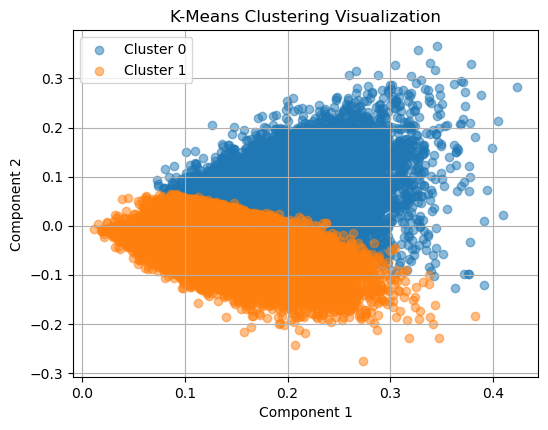

In [27]:
plt.figure(figsize=(6, 4.5))
for cluster_num in range(2):
    plt.scatter(text_svd[data['cluster_label'] == cluster_num, 0],
                text_svd[data['cluster_label'] == cluster_num, 1],
                label=f'Cluster {cluster_num}',
                alpha=0.5)

plt.title('K-Means Clustering Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()

To understand how the k-means model performs, the sentiment of each text and the predicted sentiment of each text is compared.


In [24]:
df = pd.DataFrame()
df["actual_sentiment"] = data["id"].apply(
    lambda id: 1 if id <= 25000 else 0)
df["cluster_label"] = data["cluster_label"]
df.head()

print(
    f"Accuracy of kmeans is: {sum(df['cluster_label'] == df['actual_sentiment'])/df.shape[0]}")

Accuracy of kmeans is: 0.5744


# References


1. Sentiment Analysis Using K Means Clustering on Microblogging Data Focused on Only the Important Sentiments </br>
   http://dx.doi.org/10.1109/ICETET-SIP-2254415.2022.9791723
